Data Processing

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

df = pd.read_csv("retail_sales_cleaned.csv")


Date column to datetime format

In [2]:
# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

Drop duplicates and missing values

In [5]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

Basic info

In [69]:
print(df.info())
print(df.head())
print(df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   Price per Unit    1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB
None
   Transaction ID        Date Customer ID  Gender  Age Product Category  \
0               1  2023-11-24     CUST001    Male   34           Beauty   
1               2  2023-02-27     CUST002  Female   26         Clothing   
2               3  2023-01-13     CUST003    Male   50      Electronics   
3               4  2023-05-21    

Visualize sales trend

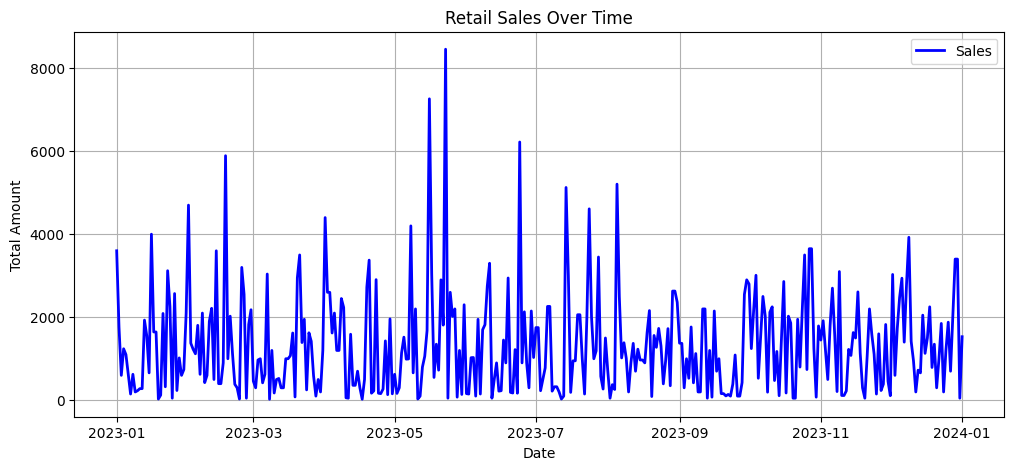

In [20]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Total Amount'], label='Sales', color='blue', linewidth=2)
plt.title("Retail Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Amount")
plt.legend()
plt.grid()
plt.show()

Check for stationarity

In [63]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Total Amount'])
print("ADF Test Statistic:", result[0])
print("p-value:", result[1])

ADF Test Statistic: -31.77601387337946
p-value: 0.0


Train-Test Split

In [11]:
train = df.iloc[:-30]
test = df.iloc[-30:]

ARIMA Model

ARIMA MAE: 811.8966868983824


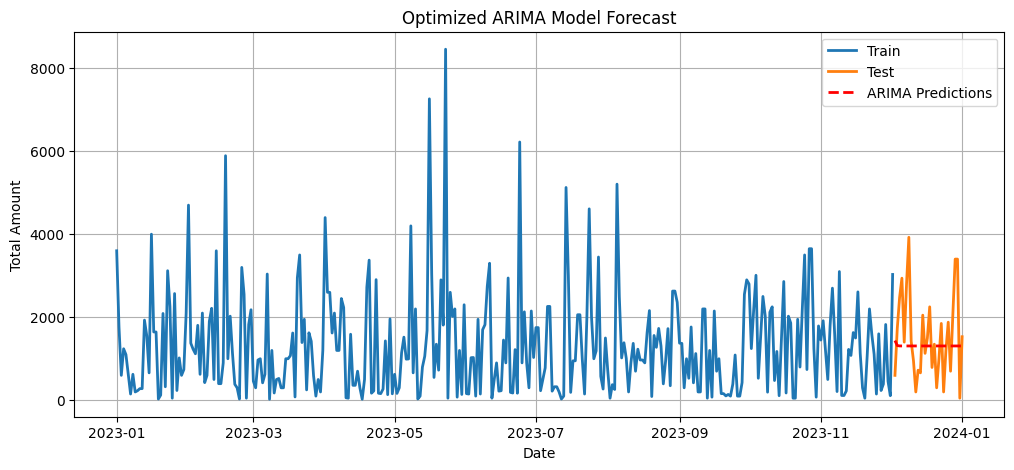

In [65]:
arima_model = ARIMA(train['Total Amount'], order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False).fit()
arima_pred = arima_model.forecast(steps=30)
mae_arima = mean_absolute_error(test['Total Amount'], arima_pred)
print("ARIMA MAE:", mae_arima)

# Plot ARIMA Results
plt.figure(figsize=(12,5))
plt.plot(train.index, train['Total Amount'], label='Train', linewidth=2)
plt.plot(test.index, test['Total Amount'], label='Test', linewidth=2)
plt.plot(test.index, arima_pred, label='ARIMA Predictions', linestyle='dashed', color='red', linewidth=2)
plt.title("Optimized ARIMA Model Forecast")
plt.xlabel("Date")
plt.ylabel("Total Amount")
plt.legend()
plt.grid()
plt.show()

SARIMA Model

SARIMA MAE: 802.0720565800299


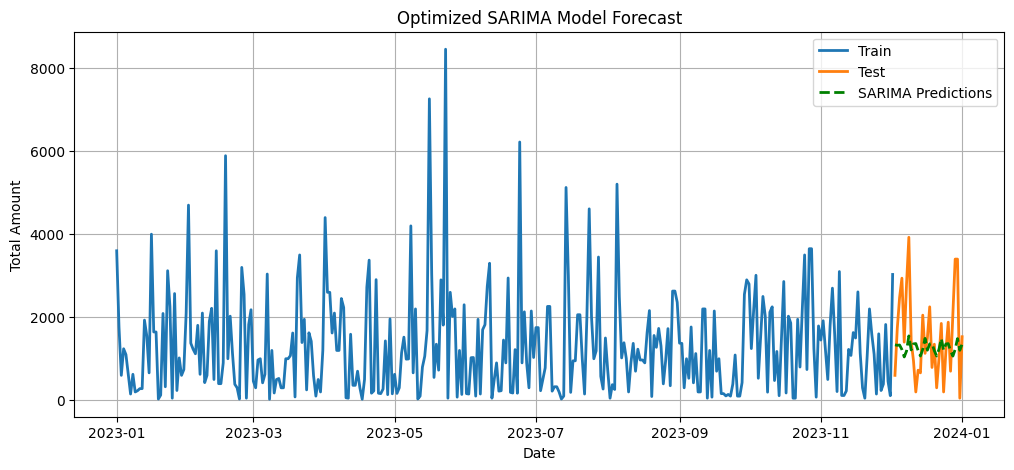

In [66]:
sarima_model = SARIMAX(train['Total Amount'], order=(1,1,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False).fit()
sarima_pred = sarima_model.forecast(steps=30)
mae_sarima = mean_absolute_error(test['Total Amount'], sarima_pred)
print("SARIMA MAE:", mae_sarima)

# Plot SARIMA Results
plt.figure(figsize=(12,5))
plt.plot(train.index, train['Total Amount'], label='Train', linewidth=2)
plt.plot(test.index, test['Total Amount'], label='Test', linewidth=2)
plt.plot(test.index, sarima_pred, label='SARIMA Predictions', linestyle='dashed', color='green', linewidth=2)
plt.title("Optimized SARIMA Model Forecast")
plt.xlabel("Date")
plt.ylabel("Total Amount")
plt.legend()
plt.grid()
plt.show()

XGB Boost Model

XGBoost MAE: 863.2154724121094


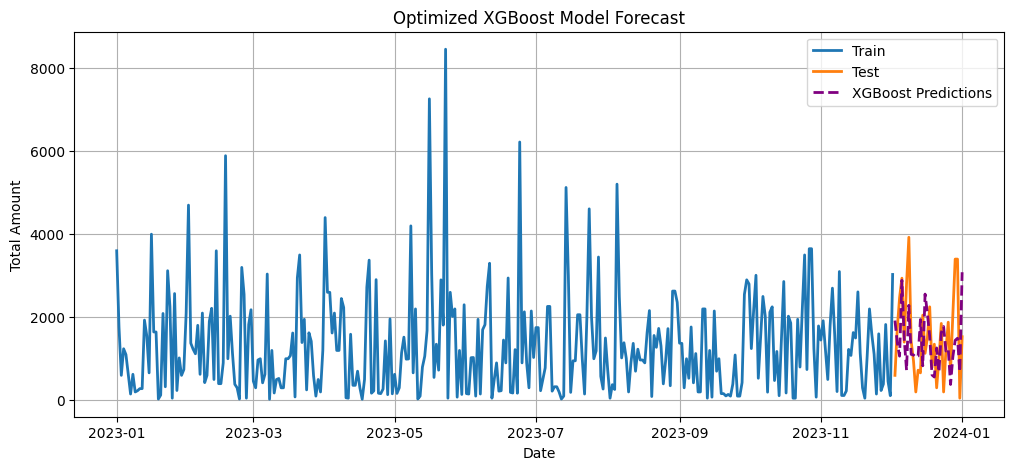

In [67]:
train['Day'] = train.index.day
test['Day'] = test.index.day
train['Month'] = train.index.month
test['Month'] = test.index.month
train['Weekday'] = train.index.weekday
test['Weekday'] = test.index.weekday

x_train = train[['Day', 'Month', 'Weekday']]
y_train = train['Total Amount']
x_test = test[['Day', 'Month', 'Weekday']]

# Scale features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.03, max_depth=6, subsample=0.9, colsample_bytree=0.9)
xgb_model.fit(x_train_scaled, y_train)
xgb_pred = xgb_model.predict(x_test_scaled)
mae_xgb = mean_absolute_error(test['Total Amount'], xgb_pred)
print("XGBoost MAE:", mae_xgb)

# Plot XGBoost Results
plt.figure(figsize=(12,5))
plt.plot(train.index, train['Total Amount'], label='Train', linewidth=2)
plt.plot(test.index, test['Total Amount'], label='Test', linewidth=2)
plt.plot(test.index, xgb_pred, label='XGBoost Predictions', linestyle='dashed', color='purple', linewidth=2)
plt.title("Optimized XGBoost Model Forecast")
plt.xlabel("Date")
plt.ylabel("Total Amount")
plt.legend()
plt.grid()
plt.show()


Comparision

In [68]:
mae_values = {"ARIMA": mae_arima, "SARIMA": mae_sarima, "XGBoost": mae_xgb}
best_model = min(mae_values, key=mae_values.get)
print("Best Model:", best_model)

Best Model: SARIMA
